In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## H6.1: Training data

In [2]:
train_x = np.zeros((120, 2))
for i, coin in enumerate(np.random.rand(60)):
    if coin < 0.5:
        train_x[i] = np.random.multivariate_normal([0, 1], 0.1 * np.identity(2))
    else:
        train_x[i] = np.random.multivariate_normal([1, 0], 0.1 * np.identity(2))
        
for i, coin in enumerate(np.random.rand(60)):
    if coin < 0.5:
        train_x[60+i] = np.random.multivariate_normal([0, 0], 0.1 * np.identity(2))
    else:
        train_x[60+i] = np.random.multivariate_normal([1, 1], 0.1 * np.identity(2))

In [3]:
train_t = np.zeros(120)
train_t[:60] = -1
train_t[60:] = 1

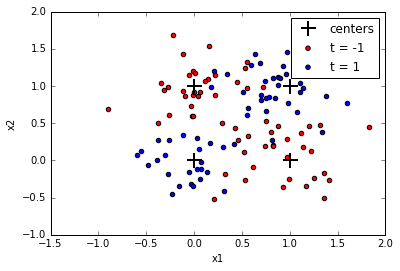

In [4]:
plt.scatter(train_x[:60, 0], train_x[:60, 1], c='r', label='t = -1')
plt.scatter(train_x[60:, 0], train_x[60:, 1], c='b', label='t = 1')
plt.plot([0, 0, 1, 1], [0, 1, 0, 1], 'k+', markersize=15, markeredgewidth=2, label='centers')
plt.legend(numpoints=1, scatterpoints=1)
plt.xlabel('x1')
plt.ylabel('x2')

## H6.2: k nearest neighbors

In [5]:
def knn(x, k=5):
    distances = np.sum((train_x - x)**2, axis=1)
    nearest = np.argsort(distances)[:k]
    if np.mean(train_t[nearest]) >= 0:
        return 1
    else:
        return -1
    
knn([0, 0]), knn([1, 0]), knn([0, 1]), knn([1, 1])

(1, -1, -1, 1)

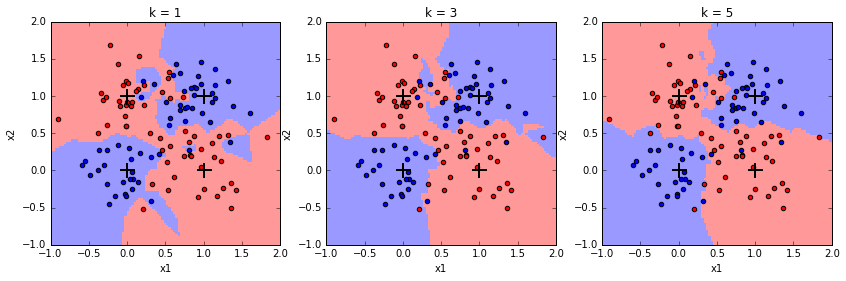

In [6]:
num_points = 100

plt.figure(figsize=(14, 4))

for subplot, k in enumerate([1, 3, 5]):
    xx, yy = np.meshgrid(np.linspace(-1, 2, num_points), np.linspace(-1, 2, num_points))
    pred_t = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            pred_t[i, j] = knn([xx[i, j], yy[i, j]], k)
                
    plt.subplot(1, 3, 1+subplot)
    plt.title('k = {}'.format(k))
    
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('rb', [[1., 0.6, 0.6], [0.6, 0.6, 1.]], 2)
    plt.pcolor(xx, yy, pred_t, cmap=cmap)

    plt.scatter(train_x[:60, 0], train_x[:60, 1], c='r', label='t = -1')
    plt.scatter(train_x[60:, 0], train_x[60:, 1], c='b', label='t = 1')
    plt.plot([0, 0, 1, 1], [0, 1, 0, 1], 'k+', markersize=15, markeredgewidth=2, label='centers')
    #plt.legend(numpoints=1, scatterpoints=1)
    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.xlim(-1, 2)
    plt.ylim(-1, 2)

## H6.2: Parzen window classifier

In [7]:
def parzen(x, variance=0.01):
    distances = np.sum((train_x - x)**2, axis=1)
    weights = np.exp(- distances / (2. * variance))    
    if np.mean(weights * train_t) >= 0:
        return 1
    else:
        return -1    

parzen([0, 0]), parzen([1, 0]), parzen([0, 1]), parzen([1, 1])

(1, -1, -1, 1)

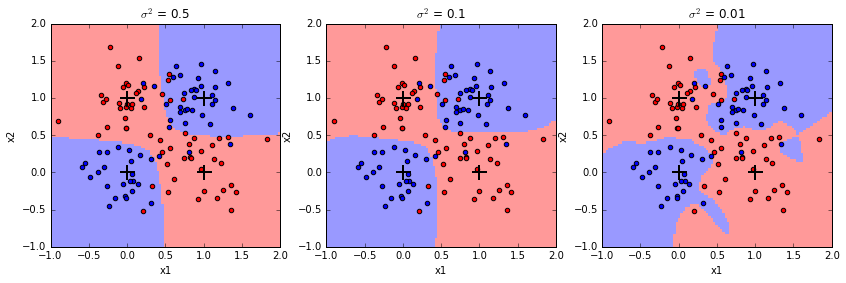

In [8]:
num_points = 100

plt.figure(figsize=(14, 4))

for subplot, variance in enumerate([0.5, 0.1, 0.01]):
    xx, yy = np.meshgrid(np.linspace(-1, 2, num_points), np.linspace(-1, 2, num_points))
    pred_t = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            pred_t[i, j] = parzen([xx[i, j], yy[i, j]], variance)
                
    plt.subplot(1, 3, 1+subplot)
    plt.title('$\sigma^2$ = {}'.format(variance))
    
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('rb', [[1., 0.6, 0.6], [0.6, 0.6, 1.]], 2)
    plt.pcolor(xx, yy, pred_t, cmap=cmap)

    plt.scatter(train_x[:60, 0], train_x[:60, 1], c='r', label='t = -1')
    plt.scatter(train_x[60:, 0], train_x[60:, 1], c='b', label='t = 1')
    plt.plot([0, 0, 1, 1], [0, 1, 0, 1], 'k+', markersize=15, markeredgewidth=2, label='centers')
    #plt.legend(numpoints=1, scatterpoints=1)
    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.xlim(-1, 2)
    plt.ylim(-1, 2)

## H6.4: RBF networks

In [9]:
from sklearn.cluster import KMeans

In [10]:
class RBF:    
    def __init__(self, k=4, variance=0.01):
        self.centers = KMeans(n_clusters=k, random_state=0).fit(train_x).cluster_centers_
        self.variance = variance
        self.k = k
        
        design_matrix = np.ones((k+1, 120))
        for j in range(k):
            for a in range(120):
                design_matrix[1+j, a] = np.exp(- np.sum((train_x[a] - self.centers[j])**2) / (2. * self.variance))

        self.w = np.linalg.pinv(design_matrix).T.dot(train_t)

    def predict(self, x):
        phi = np.ones((self.k+1, 1))
        for i in range(self.k):
            phi[1+i] = np.exp(- np.sum((x - self.centers[i])**2) / (2. * self.variance))

        return np.sign(self.w.T.dot(phi))[0]
    
rbf = RBF()
rbf.predict([0, 0]), rbf.predict([1, 0]), rbf.predict([0, 1]), rbf.predict([1, 1])

(1.0, -1.0, -1.0, 1.0)

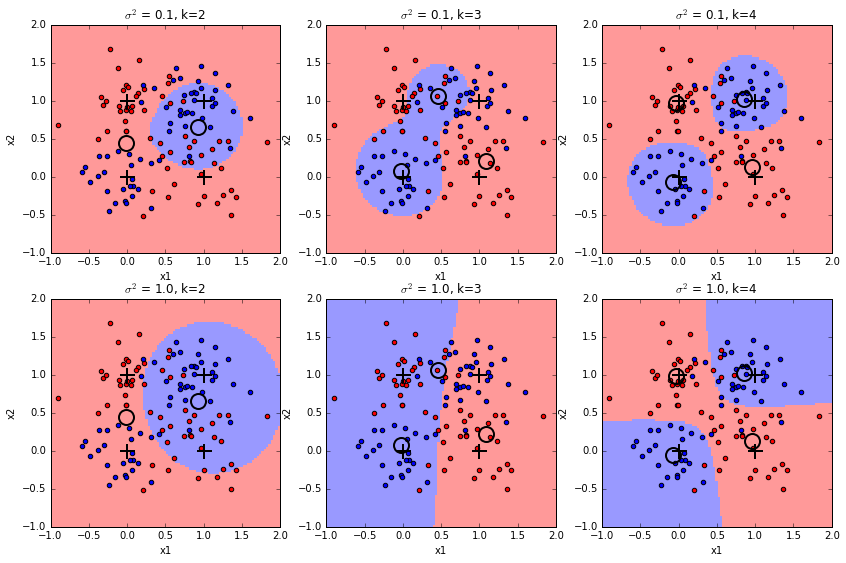

In [11]:
num_points = 100

plt.figure(figsize=(14, 9))

for subplot_y, variance in enumerate([0.1, 1.]):
    for subplot_x, k in enumerate([2, 3, 4]):

        xx, yy = np.meshgrid(np.linspace(-1, 2, num_points), np.linspace(-1, 2, num_points))
        pred_t = np.zeros((num_points, num_points))

        rbf = RBF(k, variance)

        for i in range(num_points):
            for j in range(num_points):
                pred_t[i, j] = rbf.predict([xx[i, j], yy[i, j]])
                
        plt.subplot(2, 3, 1 + subplot_y*3 + subplot_x)
        plt.title('$\sigma^2$ = {}, k={}'.format(variance, k))

        cmap = matplotlib.colors.LinearSegmentedColormap.from_list('rb', [[1., 0.6, 0.6], [0.6, 0.6, 1.]], 2)
        plt.pcolor(xx, yy, pred_t, cmap=cmap)

        plt.scatter(train_x[:60, 0], train_x[:60, 1], c='r', label='t = -1')
        plt.scatter(train_x[60:, 0], train_x[60:, 1], c='b', label='t = 1')
        plt.plot([0, 0, 1, 1], [0, 1, 0, 1], 'k+', markersize=15, markeredgewidth=2, label='centers')
        plt.plot(rbf.centers[:, 0], rbf.centers[:, 1], 'ko', markersize=15, markeredgewidth=2, mfc='none', label='predicted centers')
        #plt.legend(numpoints=1, scatterpoints=1)
        plt.xlabel('x1')
        plt.ylabel('x2')

        plt.xlim(-1, 2)
        plt.ylim(-1, 2)